# Optimize the set of samples for limited learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
class Const:
    """All constants collected together."""
    img_size = 28
    nclasses = 10
    #ind = [1,77,5,50,20,0,13,15,41,4] # Optimized training indices
    ind = [21, 276, 1397, 1409, 257, 537, 83, 96, 94, 247] # ths one grants 70% accuracy
    
C = Const()

In [5]:
(xtrain,ytrain), (xtest,ytest) = tf.keras.datasets.mnist.load_data()

def scale_mnist(x):
    x  = x.astype('float32')/255
    x = np.expand_dims(x,3) # Weird extra axis for channels, to make keras work
    return x
    
xtrain = scale_mnist(xtrain)
xtest  = scale_mnist(xtest)

ytrain = tf.keras.utils.to_categorical(ytrain, C.nclasses)
ytest  = tf.keras.utils.to_categorical(ytest, C.nclasses)

In [21]:
def _compile_model(model):
    """Helper function, just to not write this out every time."""
    model.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])    
    return model

def build_model():
    """Build a naive model, then compile."""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(C.img_size, C.img_size, 1)), # Universal input layer
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(C.nclasses, activation='softmax')
    ])
    return _compile_model(model)

def reset_last_layer(model):
    """Reset last layer (actually copy all except the last layer)."""
    model2 = tf.keras.Sequential()
    for layer in model.layers[:-1]: # Copy from input model
        model2.add(layer)
    model2.add(tf.keras.layers.Dense(C.nclasses, activation='softmax')) # Last layer
    for layer in model2.layers[:-1]:
        layer.trainable = False
    return _compile_model(model2)

model = build_model()
#model.summary()

In [11]:
class PrintDot(tf.keras.callbacks.Callback):
    """Helper function to report running loss during training."""
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print(f" {logs['loss']:.3f}".replace('0.','.'), end='')

Accuracy:  0.6266


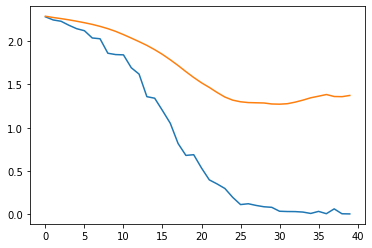

In [14]:
# Overfit with partial data:
model = build_model()
hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=40,
                  verbose=0,
                  validation_data=(xtest, ytest)) # Note that it's not validation, but rather test data

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

score = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: ',score[1])


 2.333 2.324 2.336 2.298 2.347 2.340 2.319 2.306 2.341 2.317
 2.296 2.303 2.316 2.288 2.323 2.291 2.305 2.323 2.291 2.320
 2.308 2.272 2.275 2.281 2.321 2.272 2.294 2.316 2.309 2.260
 2.313 2.308 2.329 2.298 2.323 2.305 2.315 2.308 2.317 2.298
 2.286 2.274 2.285 2.295 2.279 2.287 2.289 2.291 2.282 2.261
 2.313 2.277 2.296 2.275 2.274 2.282 2.279 2.293 2.287 2.289
 2.283 2.291 2.278 2.283 2.287 2.290 2.266 2.294 2.266 2.266
 2.283 2.244 2.261 2.292 2.286 2.256 2.298 2.266 2.279 2.287
 2.290 2.251 2.278 2.261 2.287 2.270 2.247 2.256 2.281 2.254
 2.278 2.266 2.250 2.281 2.243 2.269 2.262 2.269 2.272 2.282
 2.259 2.290 2.238 2.248 2.230 2.271 2.245 2.274 2.266 2.255
 2.255 2.227 2.276 2.244 2.231 2.240 2.288 2.279 2.239 2.260
 2.271 2.257 2.237 2.257 2.241 2.261 2.258 2.258 2.246 2.265
 2.251 2.230 2.250 2.255 2.238 2.238 2.225 2.240 2.248 2.258
 2.244 2.244 2.234 2.272 2.235 2.226 2.242 2.252 2.242 2.263
 2.238 2.238 2.253 2.217 2.212 2.260 2.235 2.248 2.223 2.246
 2.224 2.236 2.234 2.22

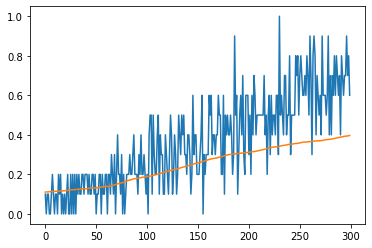

In [29]:
# Randomize all layers, but only train last layer
model = build_model()
model = reset_last_layer(model)

hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=300,
                  verbose=0,
                  callbacks=[PrintDot()],
                  validation_data=(xtest, ytest))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

score = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: ',score[1])


 2.303 2.301 2.301 2.301 2.300 2.300 2.299 2.297 2.296 2.294
 2.293 2.289 2.286 2.283 2.278 2.273 2.267 2.261 2.254 2.247
 2.238 2.233 2.227 2.217 2.211 2.201 2.194 2.186 2.180 2.171
 2.162 2.154 2.145 2.137 2.132 2.125 2.117 2.106 2.101 2.096
 2.090 2.083 2.074 2.067 2.061 2.054 2.052 2.044 2.042 2.034
 2.030 2.023 2.012 2.013 2.010 1.997 1.994 1.991 1.988 1.983
 1.972 1.971 1.968 1.966 1.962 1.952 1.950 1.946 1.944 1.938
 1.933 1.928 1.929 1.925 1.916 1.916 1.913 1.910 1.906 1.906
 1.897 1.897 1.892 1.892 1.883 1.886 1.884 1.875 1.870 1.865
 1.865 1.864 1.860 1.860 1.859 1.850 1.849 1.847 1.848 1.846
 1.844 1.838 1.839 1.836 1.832 1.828 1.831 1.824 1.821 1.819
 1.817 1.817 1.815 1.813 1.813 1.807 1.808 1.803 1.799 1.798
 1.798 1.797 1.793 1.793 1.789 1.791 1.791 1.783 1.780 1.785
 1.778 1.777 1.777 1.772 1.772 1.775 1.768 1.771 1.767 1.763
 1.767 1.764 1.757 1.760 1.762 1.758 1.756 1.751 1.752 1.746
 1.752 1.743 1.747 1.746 1.743 1.744 1.744 1.744 1.739 1.736
 1.733 1.736 1.737 1.72

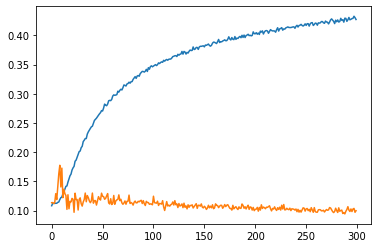

In [30]:
# Pre-training on random data:
model = build_model()
randints = np.random.choice(range(len(ytrain)), size=len(ytrain), replace=False)
hist = model.fit(xtrain, ytrain[randints],
                  batch_size=1024,
                  epochs=300,
                  verbose=0,
                  callbacks=[PrintDot()],
                  validation_data=(xtest, ytest))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

score = model.evaluate(xtest, ytest, verbose=0)
print('\nAccuracy: ',score[1])


Accuracy:  0.345


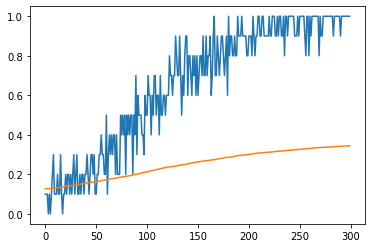

In [31]:
# Now post-train on partial labels
model = reset_last_layer(model)
hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=300,
                  verbose=0,
                  callbacks=[PrintDot()],
                  validation_data=(xtest, ytest))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

score = model.evaluate(xtest, ytest, verbose=0)
print('\nAccuracy: ',score[1])


Accuracy:  0.3787


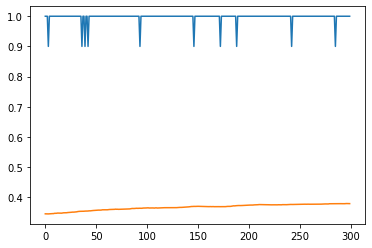

In [32]:
# And now, post-overfit on partial labels
for layer in model.layers:
    layer.trainable = True
hist = model.fit(xtrain[C.ind], ytrain[C.ind],
                  batch_size=1024,
                  epochs=300,
                  verbose=0,
                  callbacks=[PrintDot()],
                  validation_data=(xtest, ytest))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

score = model.evaluate(xtest, ytest, verbose=0)
print('\nAccuracy: ',score[1])

# Summary

* Overfit 10 labels: 0.6266 accuracy
* Train last layer with random other layers: 0.3967
* Pre-train on random labels, then train last layer: 0.345 (counter-intuitively, the result is worse as the representation is better, in a way, and we reach perfect fit of 10 labels before it becomes generalizable for the set)
* Post-fit for 10 labels: 0.3787 (not taht much difference, compared to only training last layer, as the fit on this small subset is almost perfect, so there's nothing to optimize in earlier layers)

**Conclusion:** pre-training on random labels makes the model more trainable, but doesn't necessarily create a useful representation, and as such, it actually hurts performance in a "generalize from a few labels" task.